In [60]:
import pandas as pd
import os
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

In [61]:
# column names : ReplicationNum, AirlineIdx, FlightDepTime, DepMarket, SSCPType, GrpSize, PaxArrTime, PaxSpeed, SSCPDelay, Visitors, LobbyDelay, DepFlightNumber, PaxType, PaxIDNum, PaxSSCPTime, PaxSPorPE

columns = ['ReplicationNum', 'AirlineIdx', 'FlightDepTime', 'DepMarket', 'SSCPType', 'GrpSize', 'PaxArrTime', 'PaxSpeed', 'SSCPDelay', 'Visitors', 'LobbyDelay', 'DepFlightNumber', 'PaxType', 'PaxIDNum']

In [62]:
def rolling_bin_max_sum(df, timeColumn, entityColumn, bin_interval=1, window=60, show_in_hhmm_format=False, plot=False):
    temp = df.copy()
    bins = pd.cut(temp[timeColumn], bins=range(0, 1441, bin_interval), right=False)
    
    grpSizeSum = temp.groupby(bins, observed=False)[entityColumn].sum()

    # Calculate rolling max of x-minute intervals
    rolling_sum = grpSizeSum.rolling(window).sum()
    rolling_max = rolling_sum.max()
    rolling_max_time = rolling_sum.idxmax()

    if plot:
        # plot
        rolling_sum_chart = rolling_sum.copy()
        rolling_sum_chart.index = rolling_sum.index.map(lambda x: x.left)
        rolling_sum_df = rolling_sum_chart.reset_index()    
        rolling_sum_df.columns = ['Time', 'Rolling Sum']
        rolling_sum_df.plot(x='Time', y='Rolling Sum', kind='line')
        plt.show()

    if show_in_hhmm_format:
        # convert to HH:MM format
        rolling_max_time_in_hhmm = str(timedelta(minutes=int(rolling_max_time.left)))[:-3]

        tempDF = pd.DataFrame({'Rolling Max': [int(rolling_max)], 'Time': [rolling_max_time_in_hhmm]})
        return tempDF
    else:

        rolling_max_time = rolling_max_time.left

        tempDF = pd.DataFrame({'Rolling Max': [int(rolling_max)], 'Time': [rolling_max_time]})
        return tempDF


In [63]:
def rolling_bin_max_sum_grouped(df, timeColumn, entityColumn, bin_interval=1, window=60, groupBy='', show_in_hhmm_format=False, plot=False):
    # Create bins for the given time column (0 to 1440 minutes, at bin_interval granularity)
    bins = pd.cut(df[timeColumn], bins=range(0, 1441, bin_interval), right=False)
    
    # Dictionary to store results for each PaxType
    results = {'PaxType': [], 'RollingMax': [], 'RollingMaxTime': []}
    
    # Iterate through each unique PaxType (groupBy category)
    for pax_type in df[groupBy].unique():
        temp_pax_type = df[df[groupBy] == pax_type]

        # Group by the time bins and sum the entity column within each bin
        grpSizeSum = temp_pax_type.groupby(bins, observed=False)[entityColumn].sum()

        # Calculate rolling sum and rolling max over the window
        rolling_sum = grpSizeSum.rolling(window=min(window, len(grpSizeSum)), min_periods=1).sum()  # Ensure rolling doesn't fail on small windows
        rolling_max = rolling_sum.max()
        rolling_max_time = rolling_sum.idxmax()

        # Check if the rolling sum is not empty
        if pd.notna(rolling_max_time):
            rolling_max_time_value = rolling_max_time.left  # Extract the left side of the interval
        else:
            rolling_max_time_value = None

        # Convert rolling max time to HH:MM format if required
        if show_in_hhmm_format and rolling_max_time_value is not None:
            rolling_max_time_value = str(timedelta(minutes=int(rolling_max_time_value)))[:-3]

        # Append results for this PaxType
        results['PaxType'].append(pax_type)
        results['RollingMax'].append(int(rolling_max) if pd.notna(rolling_max) else 0)
        results['RollingMaxTime'].append(rolling_max_time_value if rolling_max_time_value is not None else 'N/A')
        
    if plot:
        fig, ax = plt.subplots()

        for pax_type in df[groupBy].unique():
            temp_pax_type = df[df[groupBy] == pax_type]
            grpSizeSum = temp_pax_type.groupby(bins, observed=False)[entityColumn].sum()
            rolling_sum_chart = grpSizeSum.rolling(window).sum()
            rolling_sum_chart.index = rolling_sum_chart.index.map(lambda x: x.left)
            rolling_sum_df = rolling_sum_chart.reset_index()
            rolling_sum_df.columns = ['Time', 'Rolling Sum']

            # show max values
            rolling_sum_df['Rolling Sum Max'] = rolling_sum_df['Rolling Sum'].max()
            rolling_sum_df['Rolling Sum Max Time'] = rolling_sum_df[rolling_sum_df['Rolling Sum'] == rolling_sum_df['Rolling Sum Max']]['Time']

            ax.plot(rolling_sum_df['Time'], rolling_sum_df['Rolling Sum'], label=f'PaxType {pax_type}')
            
            # Annotate max values and their times
            for i in range(len(rolling_sum_df)):
                if rolling_sum_df['Rolling Sum'][i] == rolling_sum_df['Rolling Sum Max'][i]:
                    ax.annotate(f'Max: {rolling_sum_df["Rolling Sum Max"][i]}', (rolling_sum_df['Time'][i], rolling_sum_df['Rolling Sum Max'][i]), textcoords='offset points', xytext=(30, -15), ha='center')
                    ax.annotate(f'Time: {rolling_sum_df["Rolling Sum Max Time"][i]}', (rolling_sum_df['Time'][i], rolling_sum_df['Rolling Sum Max'][i]), textcoords='offset points', xytext=(30, -25), ha='center')

        ax.set_xlabel('Time')
        ax.set_ylabel('Rolling Sum')
        ax.legend(title='PaxType')
        ax.set_title('Rolling Sum for Each PaxType')

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)   
    
    return results_df

In [64]:
def getPeaks(folder, window = 60, show_in_hhmm_format=True, plot=False, plotNoGroup=False):
    
    all_data, all_data_grouped = {}, {}
    
    # read all csv files in the folder
    files = os.listdir(folder)
    if len(files) == 0:
        return None
    
    for file in files:
        if file.endswith('.csv'):
            df = pd.read_csv(folder + '/' + file, header=None, names=columns)
            
            # if SSCPType == 1 or 2, then PaxSPorPE = 1
            # if SSCPType == 3 or 4, then PaxSPorPE = 2
            df['PaxSPorPE'] = df['SSCPType'].apply(lambda x: 1 if x in [1, 2] else 2)

            df['PaxSSCPTime'] = df['PaxArrTime'] + df['LobbyDelay']

            # sort by PaxSSCPTime
            df = df.sort_values(by='PaxSSCPTime')

            result = rolling_bin_max_sum_grouped(df, 'PaxSSCPTime', 'GrpSize', bin_interval=1, window=window, groupBy='PaxSPorPE', show_in_hhmm_format=show_in_hhmm_format, plot=plot)

            result_no_group = rolling_bin_max_sum(df, 'PaxSSCPTime', 'GrpSize', bin_interval=1, window=window, show_in_hhmm_format=show_in_hhmm_format, plot=plotNoGroup)

            # add to dictionary with filename as key   
            all_data[file] = result_no_group
            all_data_grouped[file] = result
            
            
    # sort by filename
    all_data = dict(sorted(all_data.items()))
    all_data_grouped = dict(sorted(all_data_grouped.items()))
    
    newDF = pd.concat(all_data.values(), keys=all_data.keys())
    newDF_grouped = pd.concat(all_data_grouped.values(), keys=all_data_grouped.keys())
    
    # save to csv
    # newDF.to_excel('peaks.xlsx')
    
    return newDF, newDF_grouped


,level_0,PaxType,RollingMax,RollingMaxTime
0,RIC2040Pax1.csv,1,1183,5:34
1,RIC2040Pax1.csv,2,687,5:40
2,RIC2040Pax10.csv,1,1195,5:34
3,RIC2040Pax10.csv,2,657,5:44
4,RIC2040Pax2.csv,2,669,5:41
5,RIC2040Pax2.csv,1,1194,5:31
6,RIC2040Pax3.csv,1,1217,5:37
7,RIC2040Pax3.csv,2,672,5:43
8,RIC2040Pax4.csv,2,591,5:32
9,RIC2040Pax4.csv,1,1239,5:29


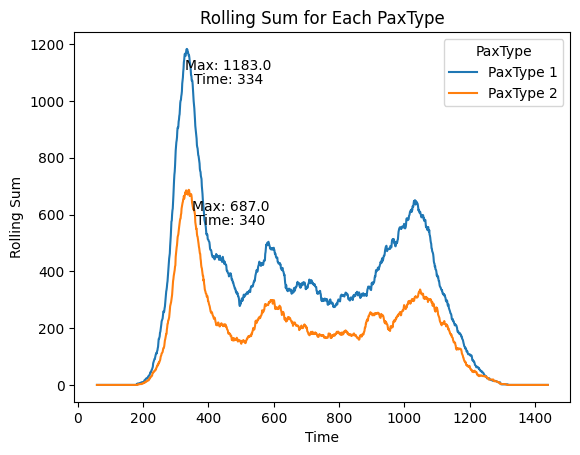

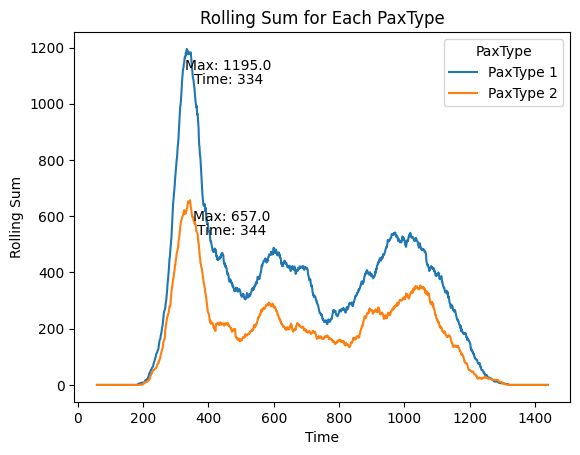

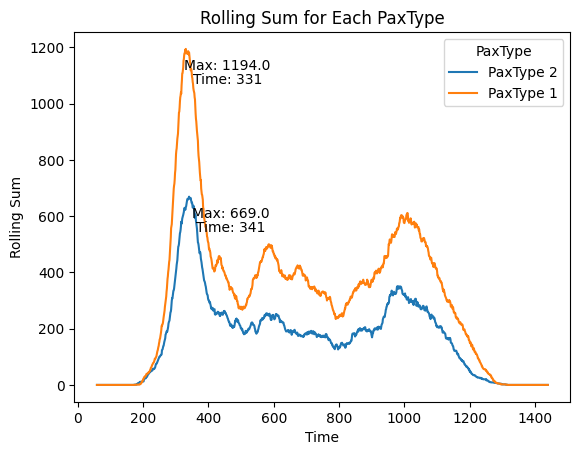

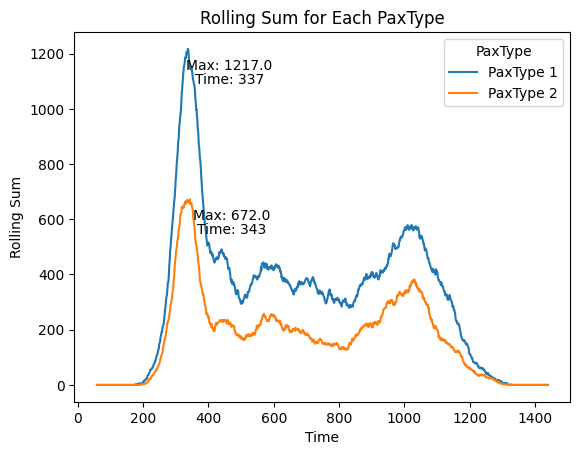

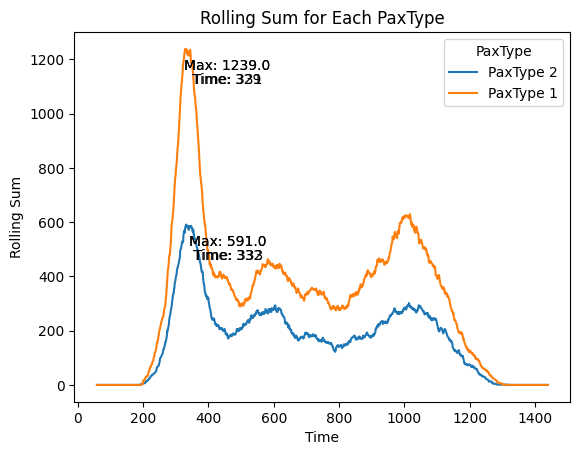

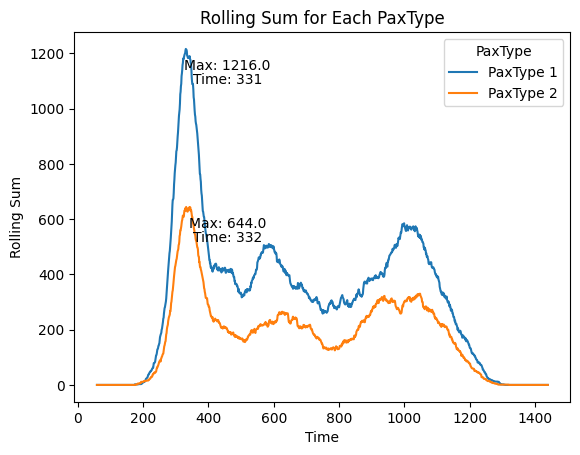

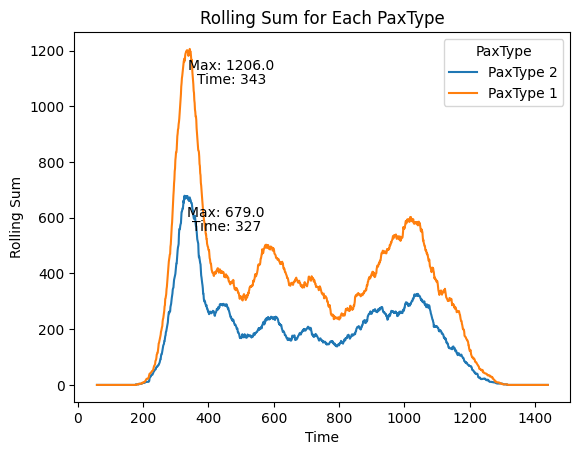

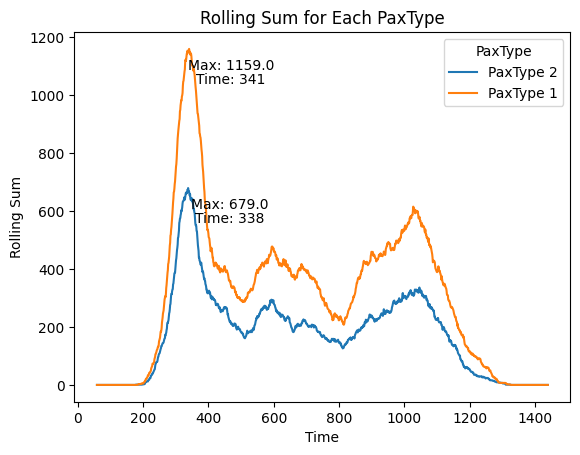

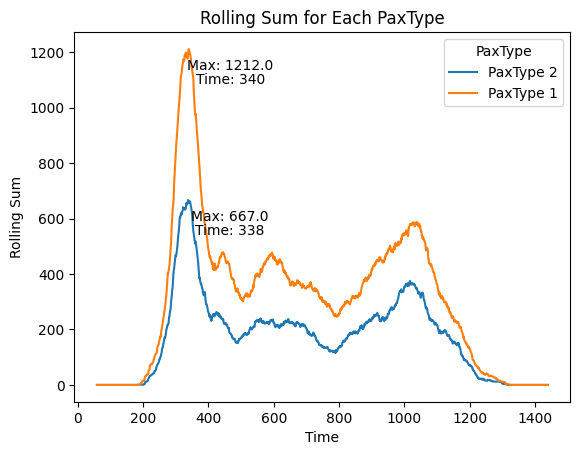

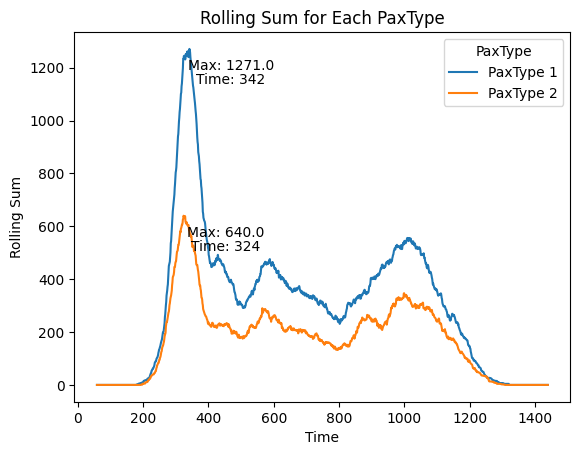

In [65]:
res, res_grped = getPeaks(folder='C:\\Users\\vnirmal\\Desktop\\RIC\\InputFiles\\2040', window=60, show_in_hhmm_format=True, plot=True)

res_grped = res_grped.reset_index()
res_grped.drop(columns=['level_1'], inplace=True)
# res_grped.drop(columns=['level_1', 'RollingMax'], inplace=True)

res_grped

In [7]:
# if 'level_0' has RIC2025Pax1.csv, then set 1
# if 'level_0' has RIC2025Pax2.csv, then set 2 and so on till 10
res_grped['level_0'] = res_grped['level_0'].apply(lambda x: int(x.split('Pax')[1].split('.')[0]))

# if PaxType is 1 then 10 else 20
res_grped['PaxType'] = res_grped['PaxType'].apply(lambda x: 10 if x == 1 else 20)

# rename level_0 to RepNum
res_grped.rename(columns={'level_0': 'RepNum'}, inplace=True)

# rename RollingMaxTime to EndTime
res_grped.rename(columns={'RollingMaxTime': 'EndTime'}, inplace=True)

# rename PaxType to New_SSCPType
res_grped.rename(columns={'PaxType': 'New_SSCPType'}, inplace=True)

# sort by RepNum and New_SSCPType
res_grped = res_grped.sort_values(by=['RepNum', 'New_SSCPType']).reset_index(drop=True)

In [ ]:
res

In [9]:
# # save as csv
# res_grped.to_csv('peaks2040.csv', index=False)
res_grped.to_excel('peaks2040.xlsx', index=False)
# # save peaks_no_grp to csv
# res.to_csv('peaks_no_grp2040.csv', index=False)
res.to_excel('peaks_no_grp2040.xlsx', index=False)